In [1]:
import os
n_cores = 4
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count={}'.format(n_cores)

from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad
import jax.random as random
key = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree
from jax.sharding import PositionalSharding
from functools import partial

import matplotlib.pyplot as plt
import matplotlib
cmap = matplotlib.colormaps['hsv']
import pandas as pd

from utils import train, eval_Cauchy_aniso, eval_Cauchy_aniso_vmap, coords_2_strain_nn
from utils import train_colloc_parallel as train_colloc, init_params_nn, ff_nn, divergence, bd_forces, a1, a2, lr
from utils_node import NODE, init_layers, NODE_model_aniso, init_params_aniso, HGO_model
from fem import plotmesh, fe_solver_2D, vahid_anisohyper_inv, apply_bc_biax

from jaxinterp2d import interp2d
import scipy.io

from jax_fem.core import FEM
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import box_mesh, get_meshio_cell_type, Mesh, rectangle_mesh

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



In [2]:
# Do the FEM with jax-fem instead
def NODE_PK1(u_grad, params, dim):
    theta = 0.0
    #Kinematics
    F_2D = u_grad + jnp.eye(dim)
    C_2D = F_2D.T @ F_2D
    Cinv_2D = jnp.linalg.inv(C_2D)
    detC_2D = jnp.linalg.det(C_2D)
    C33 = 1/detC_2D
    C = jnp.array([  [C_2D[0,0], C_2D[0,1], 0],\
                    [C_2D[1,0], C_2D[1,1], 0],\
                    [0,         0,       C33]])
    C2 = C @ C
    Cinv = jnp.linalg.inv(C)
    I1 = C[0,0] + C[1,1] + C[2,2]
    trC2 = C2[0,0] + C2[1,1] + C2[2,2]
    I2 = 0.5*(I1**2 - trC2)
    v0 = jnp.array([ jnp.cos(theta), jnp.sin(theta), 0])
    w0 = jnp.array([-jnp.sin(theta), jnp.cos(theta), 0])
    V0 = jnp.outer(v0, v0)
    W0 = jnp.outer(w0, w0)
    Iv = jnp.einsum('ij,ij',C,V0)
    Iw = jnp.einsum('ij,ij',C,W0)

    # Energy/Stress
    model = HGO_model(params)
    Psi1 = model.Psi1(I1,I2,Iv,Iw)
    Psi2 = model.Psi2(I1,I2,Iv,Iw)
    Psiv = model.Psiv(I1,I2,Iv,Iw)
    Psiw = model.Psiw(I1,I2,Iv,Iw)
    
    p = -C[2,2]*(2*Psi1 + 2*Psi2*(I1 - C[2,2]) + 2*Psiv*V0[2,2] + 2*Psiw*W0[2,2])
    S = p*Cinv + 2*Psi1*jnp.eye(3) + 2*Psi2*(I1*jnp.eye(3)-C) + 2*Psiv*V0 + 2*Psiw*W0
    S_2D = S[:2,:2]
    P_2D = F_2D @ S_2D
    return P_2D
NODE_vmap = vmap(NODE_PK1, in_axes=(0,0,None))
def NODE_sigma(u_grad, params, dim):
    F_2D = u_grad + jnp.eye(dim)
    P_2D = NODE_PK1(u_grad, params, dim)
    return P_2D @ F_2D.T
NODE_sigma_vmap = vmap(NODE_sigma, in_axes=(0,0,None))
class NODE_HyperElasticity(FEM):
    def get_tensor_map(self):
        return lambda u_grad, params: NODE_PK1(u_grad, params, self.dim)
    
    def set_params(self, params_vec):
        self.internal_vars['laplace'] = [params_vec]

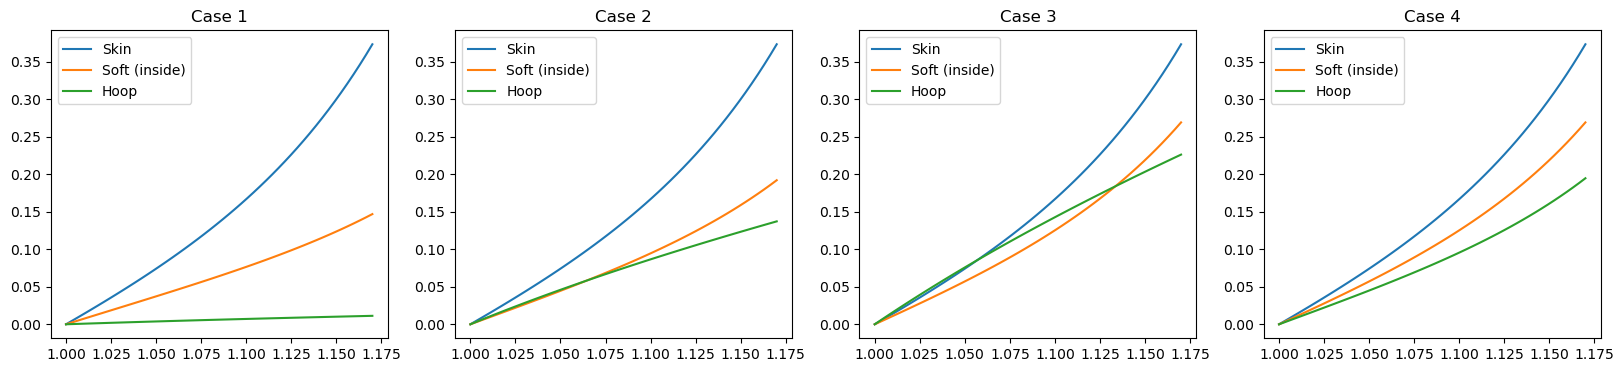

In [3]:
# Define material properties
params_skin = np.array([-3.07447, -5.88107, -0.56142,  1.05916,  0.92404, -0.64479])
params_soft = np.array([-3.07447, -10.0000, -2.00000,  1.05916,  0.92404, -0.64479])
params_hoop = np.array([-5.00000, -10000.0, -10000.0,  0.00000,  0.00000,  0.00000])
params_case1 = [params_skin, params_soft, params_hoop]

params_skin = np.array([-3.07447, -5.88107, -0.56142,  1.05916,  0.92404, -0.64479])
params_soft = np.array([-3.07447, -10.0000, -1.50000,  1.05916,  0.92404, -0.64479])
params_hoop = np.array([-2.50000, -10000.0, -10000.0,  0.00000,  0.00000,  0.00000])
params_case2 = [params_skin, params_soft, params_hoop]

params_skin = np.array([-3.07447, -5.88107, -0.56142,  1.05916,  0.92404, -0.64479])
params_soft = np.array([-3.07447, -5.88107, -1.00000,  1.05916,  0.92404, -0.64479])
params_hoop = np.array([-2.00000, -10000.0, -10000.0,  0.00000,  0.00000,  0.00000])
params_case3 = [params_skin, params_soft, params_hoop]

params_skin = np.array([-3.07447, -5.88107, -0.56142,  1.05916,  0.92404, -0.64479])
params_soft = np.array([-3.07447, -5.88107, -1.00000,  1.05916,  0.92404, -0.64479])
params_hoop = np.array([-3.07447, -5.88107, -1.50000,  1.05916,  0.92404, -0.64479])
params_case4 = [params_skin, params_soft, params_hoop]

params = [params_case1, params_case2, params_case3, params_case4]

fig, ax = plt.subplots(1,4, figsize=(20,4))
lmb = np.linspace(1,1.17)

for i in range(len(params)):
    params_skin, params_soft, params_hoop = params[i]
    
    skin_model = HGO_model(params_skin)
    sgmx_skin = eval_Cauchy_aniso_vmap(lmb, lmb, skin_model)[:,0,0]
    ax[i].plot(lmb, sgmx_skin, label='Skin')

    soft_model = HGO_model(params_soft)
    sgmx_soft = eval_Cauchy_aniso_vmap(lmb, lmb, soft_model)[:,0,0]
    ax[i].plot(lmb, sgmx_soft, label='Soft (inside)')

    hoop_model = HGO_model(params_hoop)
    sgmx_hoop = eval_Cauchy_aniso_vmap(lmb, lmb, hoop_model)[:,0,0]
    ax[i].plot(lmb, sgmx_hoop, label='Hoop')

    ax[i].legend()
    ax[i].set(title='Case ' + str(i+1))

In [4]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 50, 50
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])
elem_X = mesh.points[mesh.cells].mean(axis=1)

# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0



F_vec = []
for i in range(len(params)):
    params_vec = []
    params_skin, params_soft, params_hoop = params[i]
    for x, y in elem_X:
        if np.sqrt((x-0.5)**2 + (y-0.5)**2) > 0.35:
            params_vec.append(params_skin)
        elif np.sqrt((x-0.5)**2 + (y-0.5)**2) < 0.25:
            params_vec.append(params_soft)
        else:
            params_vec.append(params_hoop)
    params_vec = jnp.array(params_vec).reshape([len(params_vec),1,-1])
    params_vec = jnp.repeat(params_vec, axis=1, repeats=4)


    lmb_max = 1.17
    n_elem = Nx*Ny
    C10 = jnp.zeros(n_elem)
    k1  = jnp.zeros(n_elem)
    k2  = jnp.zeros(n_elem)
    F_hist = []
    node_x_hist = []
    sigma_hist = []
    dirichlet_bc_info = [
        [bottom,            left,           top,                                        right,                                  ],
        [1,                 0,              1,                                          0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),   lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = NODE_HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)

    problem.set_params(params_vec)


    node_x = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(node_x), axis=1)
    F = u_grad + np.eye(2)
    sigma = NODE_sigma_vmap(u_grad, params_vec[:,0,:], 2)
    F_vec.append(F)

[01-18 12:27:57][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[01-18 12:27:57][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[01-18 12:27:57][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[01-18 12:27:58][DEBUG] jax_fem: Done pre-computations, took 0.6521859169006348 [s]
[01-18 12:27:58][INFO] jax_fem: Solving a problem with 2500 cells, 2601x2 = 5202 dofs.
[01-18 12:27:58][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[01-18 12:27:58][DEBUG] jax_fem: Start timing
[01-18 12:27:58][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-18 12:27:59][DEBUG] jax_fem: Function split_and_compute_cell took 0.7950 seconds
[01-18 12:27:59][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-18 12:27:59][DEBUG] jax_fem: Linear guess solve...
[01-18 12:27:59][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[01-18 12:27:59][DEBUG] jax_fem: PET

In [15]:
C = np.einsum('...ji, ...jk -> ...ij', F, F)
E = np.zeros_like(C)
for i in range(len(C)):
    E[i] = 1/2*(C[i]-np.eye(2))
E.shape

(2500, 2, 2)

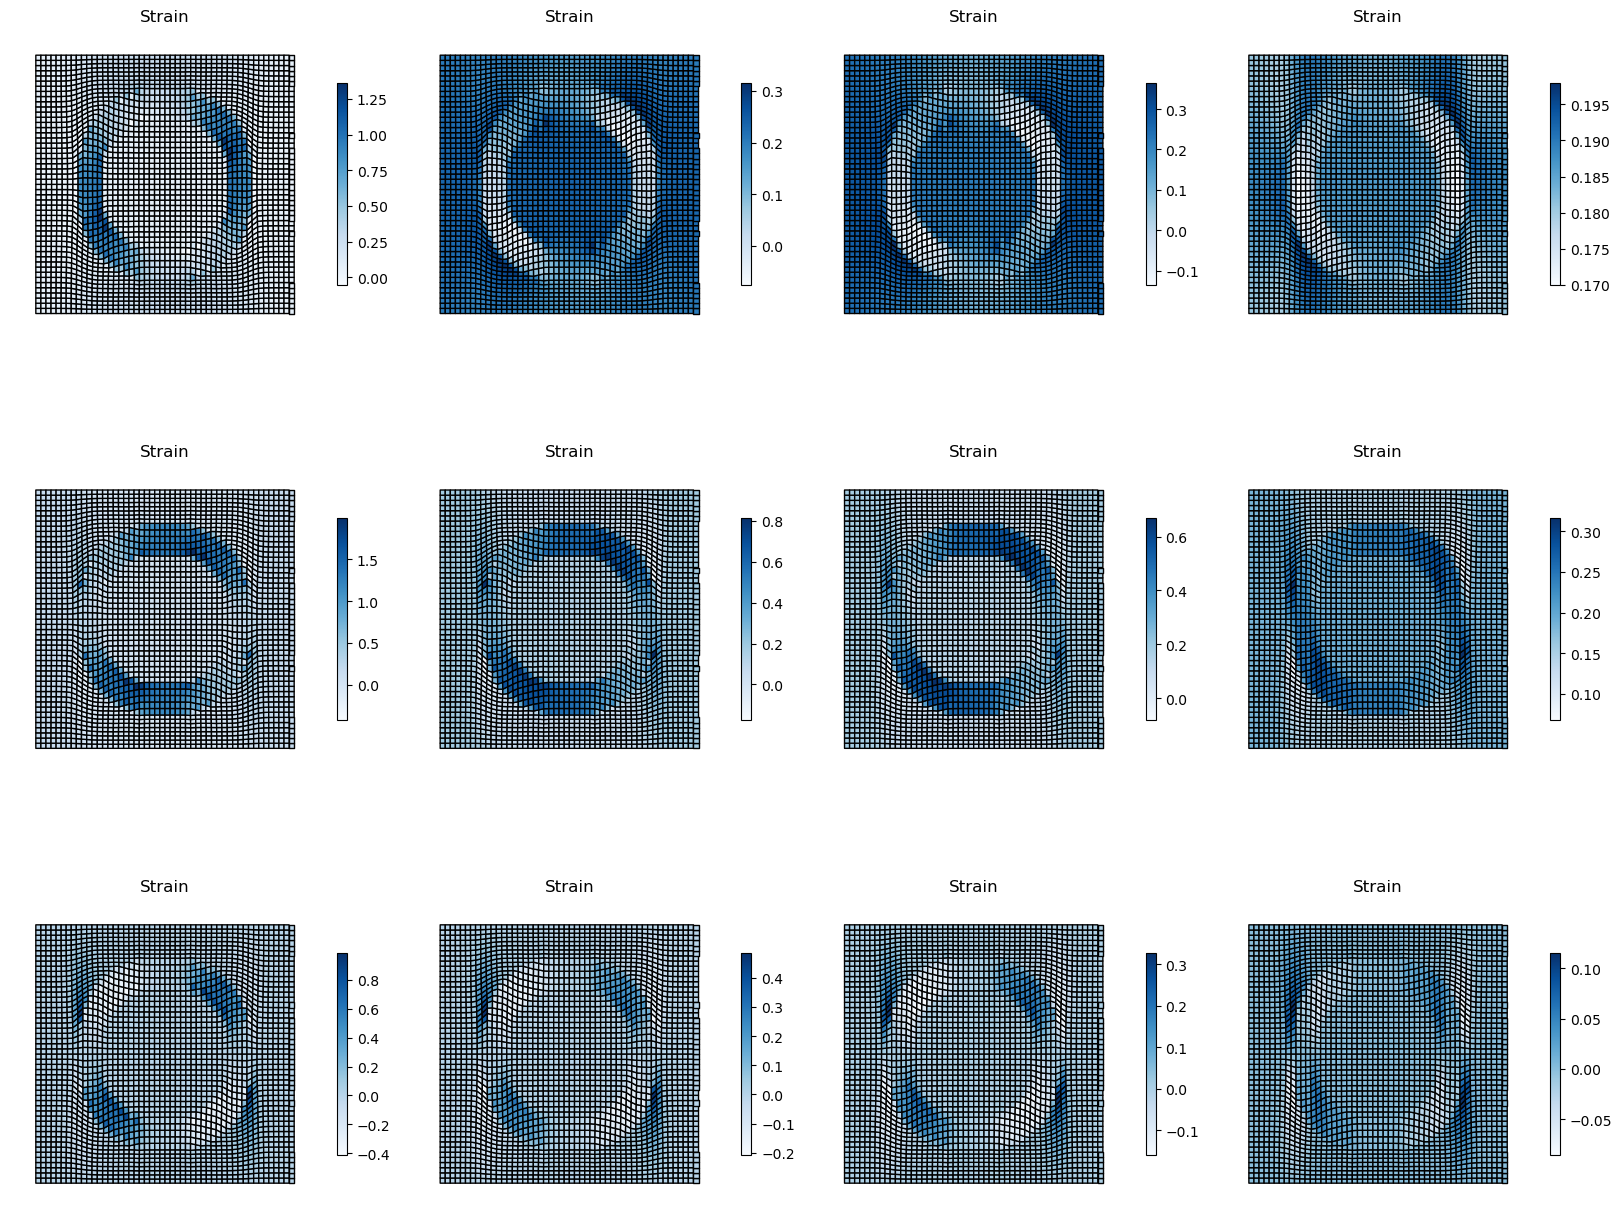

In [19]:
fig, axes = plt.subplots(3,4,figsize=(20,16))
for i in range(len(F_vec)):
    F = F_vec[i]
    C = np.einsum('...ji, ...jk -> ...ij', F, F)
    E = np.zeros_like(C)
    for j in range(len(C)):
        E[j] = 1/2*(C[j]-np.eye(2))

    plotmesh(mesh.cells, node_x, E[:,0,0], title='Strain', ax=axes[0,i]); 
    plotmesh(mesh.cells, node_x, E[:,1,1], title='Strain', ax=axes[1,i]); 
    plotmesh(mesh.cells, node_x, E[:,0,1], title='Strain', ax=axes[2,i]); 